In [1]:
from email import message_from_string
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import torch
import re

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("./dataset/Processed_datasets/nazario_2015_dataset.csv")

def extract_mail_components(text):
    try:
        msg = message_from_string(text)
        m_body = msg.get_payload()
        m_from = msg.get('From', '')
        m_return = msg.get('Return-Path', '')

        re_find = r'<([^>]*)>' 

        m_from = re.findall(re_find, m_from)[0] if re.findall(re_find, m_from) else ''
        m_return = re.findall(re_find, m_return)[0] if re.findall(re_find, m_return) else ''

        m_body = str(m_body)
        m_from = str(m_from)
        m_return = str(m_return)

        return m_body, m_from, m_return
    except Exception as e:
        print(f"Error processing text: {text[:100]}... Error: {e}")
        return '', '', ''  # Return empty values if there is an error processing the text

def extract_urls(text):
    import re
    url_list = []
    ipv4_pattern = r'(?:https?|ftp)?://(?:\d{1,3}\.){3}\d{1,3}(?::\d+)?(?:/\S*)?'
    url_pattern = (
        r'(?:(?:https?|ftp):\/\/)?'
        r'(?:[a-zA-Z0-9.%+-]+:[a-zA-Z0-9.%+-]+@)?'
        r'(?:www\.)?[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'
        r'(?:\/\S*)?'
        r'|'
        + ipv4_pattern
    )
    email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'

    # Split the input string into words
    words = text.split()

    for word in words:
        if re.fullmatch(email_pattern, word):
            # Check if it also matches a URL and additional conditions
            if re.fullmatch(url_pattern, word):
                if word.count('@') > 1 or ":" in word.split('@')[-1]:
                    url_list.append(word)
        elif re.fullmatch(url_pattern, word):
            url_list.append(word)

    return url_list

# Function to check if 'From' header contains an IP address
def contains_ip_address(from_header):
    # Regex pattern for matching IPv4 addresses
    ip_pattern = r'(?:\d{1,3}\.){3}\d{1,3}'
    # Check if the 'From' header matches the IP address pattern
    return bool(re.search(ip_pattern, from_header))

# Function to check if domains match between 'From' and 'Return-Path'
def domains_match(from_email, return_path_email):
    # Extract domains from email addresses
    domain_pattern = r'@([a-zA-Z0-9.-]+\.[a-zA-Z]{2,})'
    from_domain = re.search(domain_pattern, from_email)
    return_path_domain = re.search(domain_pattern, return_path_email)

    # Return True if domains match, False otherwise
    if from_domain and return_path_domain:
        return from_domain.group(1) == return_path_domain.group(1)
    return False  # Return False if either domain is missing

# Function to check if 'Return-Path' is missing
def is_return_path_missing(return_path):
    return not return_path.strip()  # True if 'Return-Path' is empty or contains only whitespace

# Function to count special characters in a string
def count_special_characters(text):
    # Regex to match special characters (anything not alphanumeric or whitespace)
    special_char_pattern = r'[^a-zA-Z0-9\s]'
    # Find all matches and return the count
    return len(re.findall(special_char_pattern, text))

def contains_http(url_list):
    """
    Check if any URL in the list uses 'http' instead of 'https'.
    Return 1 if 'http' URLs are found, otherwise 0.
    """
    for url in url_list:
        if url.startswith("http://"):
            return True  # Return 1 if an 'http' URL is found
    return False  # Return 0 if no 'http' URL is found

def contains_ip(url_list):
    """
    Check if any URL in the list contains an IP address in X.X.X.X format.
    Return 1 if an IP address is found, otherwise 0.
    """
    # Regular expression to match IP address format in the URL
    ipv4_pattern = r'(?:\d{1,3}\.){3}\d{1,3}'
    
    for url in url_list:
        # Check if the URL contains an IP address in the X.X.X.X format
        if re.search(ipv4_pattern, url):
            return True  # Return 1 if an IP address is found
    return False  # Return 0 if no IP address is found

def contains_html(text):
    # Regex to match valid HTML tags
    html_pattern = r'<[a-zA-Z][a-zA-Z0-9-]*(\s+[a-zA-Z_:][a-zA-Z0-9_\-:]*="[^"]*")*\s*\/?>'
    
    # Exclude patterns that are not valid HTML
    invalid_tag_patterns = [
        #r'<[a-zA-Z0-9.-]+>',  # Tags like <cwg-dated-1030377287.06fa6d>
        r'<[a-zA-Z0-9._%-]+@[a-zA-Z0-9.-]+>',  # Email-like patterns
        r'<\d+>',  # Numeric-only tags like <12345>
        r'<[a-zA-Z0-9._%-]+(\.\w+)+>'  # File-like patterns like <file-name.doc>
    ]
    
    # Check for valid HTML tags
    if re.search(html_pattern, text):
        # Ensure it doesn't match invalid tag patterns
        for pattern in invalid_tag_patterns:
            if re.search(pattern, text):
                return False
        return True
    return False

def contains_redirect(url_list):
    """
    Check if any URL in the list contains structural patterns indicating redirection.
    Return 1 if a redirect pattern is detected, otherwise 0.
    """
    for url in url_list:

        if url.startswith("mailto:"):
            continue

        # Check for multiple `//` after the protocol (excluding `http://` or `https://`)
        if url.count("//") > 1:
            return True  # Redirect detected

        # Check for the presence of `@` in the URL
        if "@" in url:
            return True  # Redirect detected

    return False  # No redirect pattern detected

def count_special_characters_in_urls(url_list):
    """
    Count the total number of special characters in all URLs within the list.
    Special characters are defined as any non-alphanumeric and non-space characters.
    """
    # Define the regex pattern for special characters
    special_char_pattern = r'[^a-zA-Z0-9\s]'

    total_count = 0
    for url in url_list:
        # Count the number of special characters in each URL using the regex pattern
        total_count += len(re.findall(special_char_pattern, url))
    
    return total_count

def length_of_longest_url(url_list):
    """
    Find the length of the longest URL in the list of URLs.
    """
    # If the list is empty, return 0
    if not url_list:
        return 0
    
    # Find the longest URL in the list and return its length
    longest_url = max(url_list, key=len)
    return len(longest_url)


df[['Body', 'From', 'Return-Path']] = df['Content'].apply(extract_mail_components).apply(pd.Series)
df['Urls'] = df['Body'].apply(extract_urls)

# Add a new column indicating if 'From' contains an IP address
df['Has_IP_in_From'] = df['From'].apply(contains_ip_address)

# Add a new column indicating if domains match between 'From' and 'Return-Path'
df['Domains_Match'] = df.apply(lambda row: domains_match(row['From'], row['Return-Path']), axis=1)

# Add a new column indicating if 'Return-Path' is missing
df['Is_Return_Path_Missing'] = df['Return-Path'].apply(is_return_path_missing)

# Add a new column indicating the number of URLs in the 'Urls' column
df['Num_Urls'] = df['Urls'].apply(len)

# Add a new column for the count of special characters in the 'Content' column
df['Num_Special_Chars'] = df['Body'].apply(count_special_characters)

# Create a new column 'Contains_HTTP' to check for 'http' URLs
df['Contains_HTTP'] = df['Urls'].apply(contains_http)

# Create a new column 'Contains_IP' to check for IP addresses in URLs
df['Contains_IP'] = df['Urls'].apply(contains_ip)

# Add a new column indicating whether 'Content' contains HTML elements
df['Contains_HTML'] = df['Body'].apply(contains_html)

# Create a new column 'Contains_Redirect' to check for redirects in URLs
df['Contains_Redirect'] = df['Urls'].apply(contains_redirect)

# Apply the function to the `Urls` column and create a new column
df['Special_Char_Count_in_URLs'] = df['Urls'].apply(count_special_characters_in_urls)

# Apply the function to the `Urls` column and create a new column
df['Longest_URL_Length'] = df['Urls'].apply(length_of_longest_url)

#Add these columns to the body

def combine_row(row):
    # Combine metadata and text using [SEP]
    combined_input = (
    f"Has_IP_in_From : {row['Has_IP_in_From']} [SEP] "
    f"Domains_Match : {row['Domains_Match']} [SEP] "
    f"Is_Return_Path_Missing : {row['Is_Return_Path_Missing']} [SEP] "
    f"Num_Urls : {row['Num_Urls']} [SEP] "
    f"Num_Special_Chars : {row['Num_Special_Chars']} [SEP] "
    f"Contains_HTTP : {row['Contains_HTTP']} [SEP] "
    f"Contains_IP : {row['Contains_IP']} [SEP] "
    f"Contains_HTML : {row['Contains_HTML']} [SEP] "
    f"Contains_Redirect : {row['Contains_Redirect']} [SEP] "
    f"Special_Char_Count_in_URLs : {row['Special_Char_Count_in_URLs']} [SEP] "
    f"Longest_URL_Length : {row['Longest_URL_Length']} [SEP] "
    f"{row['Body']}"
    )
    
    return combined_input

# Apply tokenization to each row
df["combined_input"] = df.apply(combine_row, axis=1)

test_texts = df['combined_input'].tolist()
test_labels = df['Label'].tolist()

tokenizer = BertTokenizer.from_pretrained("saved_model_withFlag")
model = BertForSequenceClassification.from_pretrained("saved_model_withFlag")

# Tokenize data
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

test_dataset = Dataset(test_encodings, test_labels)

In [5]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)
model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs = {key: val.to(model.device) for key, val in batch.items() if key != 'labels'}
        outputs = model(**inputs)
        preds.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())

# Evaluation metrics
print("Accuracy:", accuracy_score(true_labels, preds))
print("Classification Report:\n", classification_report(true_labels, preds))

C:\Users\Asus\AppData\Local\Temp\ipykernel_9120\1587964162.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Accuracy: 0.9084967320261438
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.91      0.95       306

    accuracy                           0.91       306
   macro avg       0.50      0.45      0.48       306
weighted avg       1.00      0.91      0.95       306



c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Confusion Matrix:
 [[  0   0]
 [ 28 278]]


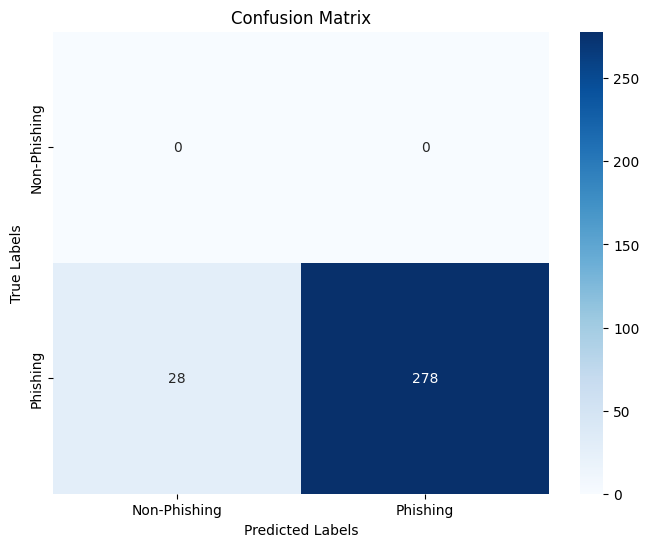

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Phishing', 'Phishing'], yticklabels=['Non-Phishing', 'Phishing'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()